In [10]:

"""
implements iteration on the bellman equations to solve the McCall model
"""

import numpy as np
from quantecon.distributions import BetaBinomial
from numba import jit

#a default utility function

@jit
def u(c, sigma):
    if c > 0:
        return (c**(1 - sigma) - 1) / (1 - sigma)
    else:
        return -10e6
    
class McCallModel:
    """
    stores the parameters and functions associated with a given model
    """
    
    def __init__(self, alpha=0.2, #job separation rate
                beta=0.98, #discount rate
                gamma=0.7, #job offer rate
                c=6.0, #unemployment compensation
                sigma=2.0, #utility parameter
                w_vec=None, #possible wage values
                p_vec=None): #probabilities over w_vec
        
        self.alpha, self.beta, self.gamma, self.c = alpha, beta, gamma, c
        self.sigma = sigma
        
        #add a default wage vector and probabilities over the vector using
        #the beta-binomial distribution
        if w_vec is None:
            n = 60 #number of possible outcomes for wage
            self.w_vec = np.linspace(10, 20, n) #wages between 10 and 20
            a, b = 600, 400 #shape parameters
            dist = BetaBinomial(n-1, a, b)
            self.p_vec = dist.pdf()
        else:
            self.w_vec = w_vec
            self.p_vec = p_vec

@jit
def _update_bellman(alpha, beta, gamma, c, sigma, w_vec, p_vec, V, V_new, U):
    """
    a jitted function to update the bellman equations. note that V_new is
    modified in place (i.e., modified by this function). the new value of U is
    returned
    
    """
    for w_idx, w in enumerate(w_vec):
        #w_idx indexes the vector of possible wages
        V_new[w_idx] = u(w, sigma) + beta * ((1 - alpha) * V[w_idx] + alpha * U)
        
    U_new = u(c, sigma) +beta * (1 - gamma) * U + \
    beta * gamma * np.sum(np.maximum(U, V) * p_vec)
    
    return U_new

def solve_mccall_model(mcm, tol=1e-5, max_iter=2000):
    """
    iterates to convergence on the bellman equations
    
    parameters
    ------
    mcm: an instance of McCallModel
    tol: float
        error tolerance
    max_iter: int
        the maximum number of iterations
    """
    
    V = np.ones(len(mcm.w_vec)) #initial guess of V
    V_new = np.empty_like(V) #to store updates to V
    U = 1 #initial guess of U
    i = 0
    error = tol + 1
    
    while error > tol and i < max_iter:
        U_new = _update_bellman(mcm.alpha, mcm.beta, mcm.gamma, 
                               mcm.c, mcm.sigma, mcm.w_vec, mcm.p_vec, V, V_new, U)
        error_1 = np.max(np.abs(V_new -V))
        error_2 = np.abs(U_new - U)
        error = max(error_1, error_2)
        V[:] = V_new
        U = U_new
        i +=1
        
    return V, U

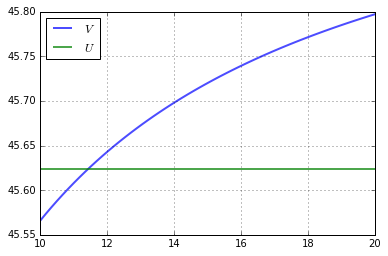

In [11]:
"""
generate plots of value of employment and unemployment in the McCall model
"""

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

mcm = McCallModel()
V, U =solve_mccall_model(mcm)

fig, ax = plt.subplots()

ax.plot(mcm.w_vec, V, 'b-', lw=2, alpha=0.7, label='$V$')
ax.plot(mcm.w_vec, [U]*len(mcm.w_vec), 'g-', lw=2, alpha=0.7, label='$U$')
ax.legend(loc='upper left')
ax.grid()

plt.show()

In [12]:
def compute_reservation_wage(mcm):
    """
    computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that V(w) > U
    
    if V(w) > U for all w, then the reservation wage w_bar is set to the
    lowest wage in mcm.w_vec.
    
    if V(w) < U for all w, then w_bar is set to np.inf
    
    parameters
    ------
    mcm: an instance of McCallModel
    
    returns
    ------
    w_bar: scalar
        the researvation wage
        
    """
    
    V, U = solve_mccall_model(mcm)
    w_idx = np.searchsorted(V-U, 0)
    
    if w_idx ==len(V) +1:
        w_bar = np.inf
    else:
        w_bar = mcm.w_vec[w_idx]
        
    return w_bar

In [13]:
compute_reservation_wage(mcm)

11.525423728813559

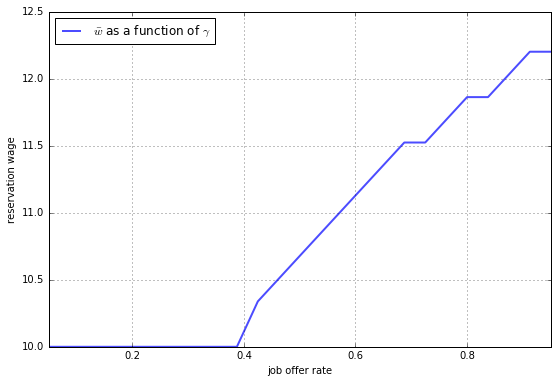

In [14]:
grid_size = 25
gamma_vals = np.linspace(0.05, 0.95, grid_size)
w_bar_vals = np.empty_like(gamma_vals)

fig, ax = plt.subplots(figsize=(9, 6))

for i, gamma in enumerate(gamma_vals):
    mcm.gamma = gamma
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar
    
ax.set_xlabel('job offer rate')
ax.set_ylabel('reservation wage')
ax.set_xlim(gamma_vals.min(), gamma_vals.max())
txt=r'$\bar w$ as a function of $\gamma$'
ax.plot(gamma_vals, w_bar_vals, 'b-', lw=2, alpha=0.7, label=txt)
ax.legend(loc='upper left')
ax.grid()

plt.show()